In [ ]:
# https://statcompute.wordpress.com/2017/01/08/an-example-of-merge-layer-in-keras/

In [1]:
from sklearn.utils import class_weight

from sklearn.model_selection import train_test_split
import numpy as np
from keras.models import Sequential
from keras.layers import Dense,Merge,Dropout
from keras.layers import LSTM

# For the plots 
import matplotlib.pyplot as plt

# For controlling the training parameters in the midst of training itself
from keras.callbacks import ModelCheckpoint,EarlyStopping, ReduceLROnPlateau

# For creating directory to save the models
import os
from imblearn.over_sampling import SMOTE

Using TensorFlow backend.


In [19]:
# Load the data
X = np.load("X (1).npy")
Y = np.load("Y (1).npy")

XT = np.column_stack( (X,Y) )
YT = []
for y in Y:
    if y==0:
        YT.append(0)
    else:
        YT.append(1)
#     elif y>0 and y<=50:
#         YT.append(1)
#     elif y>50 and y<=100:
#         YT.append(2)
#     elif y>100 and y<=150:
#         YT.append(3)
#     elif y>150 and y<=200:
#         YT.append(4)
        
YT = np.array(YT)

In [20]:
# Split the test train and pass it into validation

# Split the test train and pass it into validation
from sklearn.utils import class_weight

X_train, X_test, Y_train, Y_test = train_test_split(XT, YT, test_size=0.2, random_state=12)
# class_weight = class_weight.compute_class_weight('balanced', np.unique(Y), Y)

sm = SMOTE(random_state=12, ratio = 1.0, k_neighbors = 5)
x_res, y_res = sm.fit_sample(X_train, Y_train)
# print (Y_train.value_counts(), np.bincount(y_res))
# weights = np.array(class_weight)

/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [21]:
X_train = x_res[:,:100]

X_train, X_test, Y_train, Y_test = train_test_split(XT, YT, test_size=0.2, random_state=12)

In [22]:
# Reshape the stuff according to the the shape Keras expects it to be !
data_lstm = X_train[:,:100].reshape((X_train[:,:100].shape[0], 100, 1))
target = Y_train.reshape((Y_train.shape[0], 1))

val_data_lstm = X_test[:,:100].reshape(X_test[:,:100].shape[0],100,1)
val_target = Y_test.reshape(Y_test.shape[0],1)

# Reshape the stuff according to the the shape Keras expects it to be !
data_lstm = x_res[:,:100].reshape((x_res[:,:100].shape[0], 100, 1))
Y_train = x_res[:,101]
target = np.round(Y_train.reshape((Y_train.shape[0], 1)))
# target = Y_train

val_data_lstm = X_test[:,:100].reshape(X_test[:,:100].shape[0],100,1)
Y_test = X_test[:,101]
val_target = Y_test.reshape(Y_test.shape[0],1)
# val_target = Y_test



In [23]:
data_lstm.shape

(4176, 100, 1)

In [24]:
data_mw = x_res[:,-1].reshape((x_res[:,-1].shape[0],1))
val_data_mw = X_test[:,-1].reshape((X_test[:,-1].shape[0],1))

In [25]:
val_data_mw.shape

(650, 1)

In [26]:
max(target)

array([ 199.])

In [29]:
# The standard model
# Here 50, the dimensionality of the output from LSTM is just a random no and has no suxh signifance, 
# That ^^ shuould be search via a hyperparameter search

branch1 = Sequential()

# The a<final output> will have 50 numbers 
branch1.add(LSTM(50, input_shape=(100, 1)))

branch2 = Sequential()
branch2.add(Dense(10,input_dim=1))
# Get those 50 numbers and put that into one output !
model =Sequential()
model.add(Merge([branch1, branch2], mode = 'concat'))
model.add(Dense(1,activation='tanh'))
branch1.add(Dropout(0.2))
model.add(Dense(1,activation='relu'))
model.add(Dense(1,activation='relu'))

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  


In [15]:
# Define the output for the saving the checkpoint (best models)

outputFolder = './output-lstm'
if not os.path.exists(outputFolder):
    os.makedirs(outputFolder)
filepath=outputFolder+"/Weights-{epoch:02d}-{val_acc:.2f}.hdf5"

In [16]:
# The callback function for model checkpoint saving
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1,save_best_only=True,\
                             save_weights_only=True,mode='auto')

# The callback function for earlystopping

earlystop = EarlyStopping(monitor='val_loss',patience=10, \
                          verbose=1, mode='auto')

# The callback function for reducing learning rate on plateus

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                              patience=3, min_lr=0.00001)

In [17]:
# Put all those calback in a list
#callbacks = [earlystop, checkpoint, reduce_lr]
callbacks = [checkpoint, reduce_lr]

In [33]:
# I have decided to use mean_absolute_error , beacuse for some reason mean squared e
# model.compile(loss='mean_absolute_error', optimizer='adam',metrics=['accuracy'])
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])


model_info = model.fit([data_lstm,data_mw], target, epochs=1000, batch_size=1000, verbose=2,validation_data=([val_data_lstm,val_data_mw],val_target))
                       #,callbacks=callbacks)

Train on 4176 samples, validate on 650 samples
Epoch 1/1000
12s - loss: 353.4794 - acc: 0.6988 - val_loss: 133.3355 - val_acc: 0.8815
Epoch 2/1000
9s - loss: 353.0672 - acc: 0.6944 - val_loss: 133.1839 - val_acc: 0.8815
Epoch 3/1000
8s - loss: 352.6668 - acc: 0.7026 - val_loss: 133.0249 - val_acc: 0.8815
Epoch 4/1000
8s - loss: 352.2657 - acc: 0.6928 - val_loss: 132.8754 - val_acc: 0.8815
Epoch 5/1000
11s - loss: 351.8769 - acc: 0.7009 - val_loss: 132.7248 - val_acc: 0.8815
Epoch 6/1000
14s - loss: 351.4771 - acc: 0.6964 - val_loss: 132.5710 - val_acc: 0.8815
Epoch 7/1000
12s - loss: 351.0739 - acc: 0.6959 - val_loss: 132.4180 - val_acc: 0.8815
Epoch 8/1000
10s - loss: 350.6675 - acc: 0.6997 - val_loss: 132.2595 - val_acc: 0.8815
Epoch 9/1000
9s - loss: 350.2547 - acc: 0.6980 - val_loss: 132.0999 - val_acc: 0.8815
Epoch 10/1000
9s - loss: 349.8391 - acc: 0.6997 - val_loss: 131.9423 - val_acc: 0.8815
Epoch 11/1000
8s - loss: 349.4273 - acc: 0.7002 - val_loss: 131.7853 - val_acc: 0.8815


14s - loss: 312.0183 - acc: 0.2395 - val_loss: 117.5577 - val_acc: 0.0877
Epoch 96/1000
10s - loss: 311.5504 - acc: 0.2368 - val_loss: 117.3796 - val_acc: 0.1031
Epoch 97/1000
9s - loss: 311.0931 - acc: 0.2447 - val_loss: 117.2078 - val_acc: 0.0908
Epoch 98/1000
8s - loss: 310.6207 - acc: 0.2452 - val_loss: 117.0294 - val_acc: 0.1000
Epoch 99/1000
8s - loss: 310.1567 - acc: 0.2452 - val_loss: 116.8525 - val_acc: 0.1000
Epoch 100/1000
8s - loss: 309.6813 - acc: 0.2462 - val_loss: 116.6749 - val_acc: 0.0908
Epoch 101/1000
8s - loss: 309.2052 - acc: 0.2469 - val_loss: 116.4930 - val_acc: 0.0985
Epoch 102/1000
8s - loss: 308.7427 - acc: 0.2488 - val_loss: 116.3165 - val_acc: 0.0969
Epoch 103/1000
7s - loss: 308.2651 - acc: 0.2498 - val_loss: 116.1439 - val_acc: 0.0923
Epoch 104/1000
8s - loss: 307.8004 - acc: 0.2466 - val_loss: 115.9659 - val_acc: 0.1015
Epoch 105/1000
8s - loss: 307.3371 - acc: 0.2483 - val_loss: 115.7892 - val_acc: 0.0908
Epoch 106/1000
8s - loss: 306.8597 - acc: 0.2471 

7s - loss: 267.5650 - acc: 0.2680 - val_loss: 100.9650 - val_acc: 0.0985
Epoch 189/1000
7s - loss: 267.0916 - acc: 0.2694 - val_loss: 100.7868 - val_acc: 0.0985
Epoch 190/1000
8s - loss: 266.6122 - acc: 0.2708 - val_loss: 100.6090 - val_acc: 0.1031
Epoch 191/1000
9s - loss: 266.1339 - acc: 0.2711 - val_loss: 100.4391 - val_acc: 0.1015
Epoch 192/1000
9s - loss: 265.6675 - acc: 0.2608 - val_loss: 100.2640 - val_acc: 0.1046
Epoch 193/1000
8s - loss: 265.2031 - acc: 0.2610 - val_loss: 100.0902 - val_acc: 0.1031
Epoch 194/1000
8s - loss: 264.7474 - acc: 0.2591 - val_loss: 99.9219 - val_acc: 0.0969
Epoch 195/1000
8s - loss: 264.2694 - acc: 0.2699 - val_loss: 99.7474 - val_acc: 0.0985
Epoch 196/1000
8s - loss: 263.7900 - acc: 0.2648 - val_loss: 99.5683 - val_acc: 0.0985
Epoch 197/1000
8s - loss: 263.2957 - acc: 0.2720 - val_loss: 99.3911 - val_acc: 0.0954
Epoch 198/1000
8s - loss: 262.8101 - acc: 0.2577 - val_loss: 99.2088 - val_acc: 0.0938
Epoch 199/1000
7s - loss: 262.3397 - acc: 0.2574 - v

8s - loss: 224.9441 - acc: 0.1588 - val_loss: 85.3673 - val_acc: 0.0308
Epoch 283/1000
8s - loss: 224.5287 - acc: 0.1583 - val_loss: 85.1887 - val_acc: 0.0400
Epoch 284/1000
8s - loss: 224.0889 - acc: 0.1592 - val_loss: 85.0527 - val_acc: 0.0354
Epoch 285/1000
8s - loss: 223.6589 - acc: 0.1698 - val_loss: 84.8916 - val_acc: 0.0308
Epoch 286/1000
8s - loss: 223.2402 - acc: 0.1669 - val_loss: 84.7445 - val_acc: 0.0369
Epoch 287/1000
8s - loss: 222.8105 - acc: 0.1729 - val_loss: 84.5950 - val_acc: 0.0369
Epoch 288/1000
7s - loss: 222.3928 - acc: 0.1664 - val_loss: 84.4361 - val_acc: 0.0354
Epoch 289/1000
8s - loss: 221.9810 - acc: 0.1676 - val_loss: 84.2852 - val_acc: 0.0354
Epoch 290/1000
8s - loss: 221.5525 - acc: 0.1667 - val_loss: 84.1468 - val_acc: 0.0431
Epoch 291/1000
7s - loss: 221.1321 - acc: 0.1705 - val_loss: 84.0079 - val_acc: 0.0369
Epoch 292/1000
7s - loss: 220.7219 - acc: 0.1614 - val_loss: 83.8252 - val_acc: 0.0400
Epoch 293/1000
7s - loss: 220.3067 - acc: 0.1691 - val_los

13s - loss: 187.9851 - acc: 0.1607 - val_loss: 71.9141 - val_acc: 0.0415
Epoch 377/1000
12s - loss: 187.6314 - acc: 0.1681 - val_loss: 71.8495 - val_acc: 0.0400
Epoch 378/1000
11s - loss: 187.2511 - acc: 0.1734 - val_loss: 71.6673 - val_acc: 0.0462
Epoch 379/1000
9s - loss: 186.8855 - acc: 0.1762 - val_loss: 71.5178 - val_acc: 0.0400
Epoch 380/1000
12s - loss: 186.5322 - acc: 0.1719 - val_loss: 71.4178 - val_acc: 0.0400
Epoch 381/1000
9s - loss: 186.1546 - acc: 0.1801 - val_loss: 71.3002 - val_acc: 0.0323
Epoch 382/1000
9s - loss: 185.8267 - acc: 0.1767 - val_loss: 71.1813 - val_acc: 0.0338
Epoch 383/1000
8s - loss: 185.4656 - acc: 0.1798 - val_loss: 71.0410 - val_acc: 0.0323
Epoch 384/1000
8s - loss: 185.1154 - acc: 0.1841 - val_loss: 70.8856 - val_acc: 0.0400
Epoch 385/1000
8s - loss: 184.7550 - acc: 0.1818 - val_loss: 70.7746 - val_acc: 0.0323
Epoch 386/1000
8s - loss: 184.3999 - acc: 0.1808 - val_loss: 70.6872 - val_acc: 0.0369
Epoch 387/1000
8s - loss: 184.0643 - acc: 0.1813 - val

11s - loss: 157.8943 - acc: 0.1868 - val_loss: 61.1440 - val_acc: 0.0415
Epoch 471/1000
9s - loss: 157.5968 - acc: 0.1937 - val_loss: 61.0464 - val_acc: 0.0385
Epoch 472/1000
9s - loss: 157.3271 - acc: 0.1858 - val_loss: 60.9289 - val_acc: 0.0292
Epoch 473/1000
9s - loss: 157.0599 - acc: 0.1856 - val_loss: 60.8020 - val_acc: 0.0354
Epoch 474/1000
10s - loss: 156.7688 - acc: 0.1918 - val_loss: 60.7092 - val_acc: 0.0277
Epoch 475/1000
10s - loss: 156.4835 - acc: 0.1973 - val_loss: 60.6104 - val_acc: 0.0369
Epoch 476/1000
11s - loss: 156.2258 - acc: 0.1894 - val_loss: 60.5330 - val_acc: 0.0338
Epoch 477/1000
11s - loss: 155.9600 - acc: 0.1844 - val_loss: 60.4657 - val_acc: 0.0246
Epoch 478/1000
10s - loss: 155.6762 - acc: 0.1880 - val_loss: 60.3340 - val_acc: 0.0354
Epoch 479/1000
10s - loss: 155.3922 - acc: 0.1909 - val_loss: 60.2420 - val_acc: 0.0308
Epoch 480/1000
11s - loss: 155.1130 - acc: 0.1882 - val_loss: 60.1204 - val_acc: 0.0354
Epoch 481/1000
14s - loss: 154.8611 - acc: 0.1844 

17s - loss: 133.1908 - acc: 0.2009 - val_loss: 52.4042 - val_acc: 0.0308
Epoch 565/1000
14s - loss: 132.9555 - acc: 0.1997 - val_loss: 52.3786 - val_acc: 0.0338
Epoch 566/1000
17s - loss: 132.7311 - acc: 0.1971 - val_loss: 52.2799 - val_acc: 0.0292
Epoch 567/1000
17s - loss: 132.5084 - acc: 0.1928 - val_loss: 52.1676 - val_acc: 0.0292
Epoch 568/1000
17s - loss: 132.2634 - acc: 0.1909 - val_loss: 52.0718 - val_acc: 0.0277
Epoch 569/1000
16s - loss: 132.0136 - acc: 0.1928 - val_loss: 51.9595 - val_acc: 0.0292
Epoch 570/1000
15s - loss: 131.8198 - acc: 0.1774 - val_loss: 51.8708 - val_acc: 0.0246
Epoch 571/1000
17s - loss: 131.5888 - acc: 0.1731 - val_loss: 51.8058 - val_acc: 0.0262
Epoch 572/1000
19s - loss: 131.3441 - acc: 0.1679 - val_loss: 51.7386 - val_acc: 0.0323
Epoch 573/1000
12s - loss: 131.0922 - acc: 0.1762 - val_loss: 51.6759 - val_acc: 0.0354
Epoch 574/1000
12s - loss: 130.8441 - acc: 0.1870 - val_loss: 51.6724 - val_acc: 0.0323
Epoch 575/1000
17s - loss: 130.6516 - acc: 0.17

8s - loss: 112.8313 - acc: 0.1985 - val_loss: 45.2979 - val_acc: 0.0246
Epoch 659/1000
8s - loss: 112.6084 - acc: 0.2100 - val_loss: 45.2861 - val_acc: 0.0231
Epoch 660/1000
9s - loss: 112.4149 - acc: 0.2117 - val_loss: 45.2236 - val_acc: 0.0231
Epoch 661/1000
9s - loss: 112.2150 - acc: 0.2083 - val_loss: 45.1565 - val_acc: 0.0215
Epoch 662/1000
8s - loss: 112.0158 - acc: 0.2086 - val_loss: 45.0605 - val_acc: 0.0215
Epoch 663/1000
8s - loss: 111.8474 - acc: 0.2126 - val_loss: 44.9726 - val_acc: 0.0246
Epoch 664/1000
8s - loss: 111.6861 - acc: 0.2050 - val_loss: 44.8831 - val_acc: 0.0215
Epoch 665/1000
10s - loss: 111.5167 - acc: 0.2021 - val_loss: 44.8342 - val_acc: 0.0262
Epoch 666/1000
11s - loss: 111.3271 - acc: 0.2062 - val_loss: 44.7501 - val_acc: 0.0231
Epoch 667/1000
10s - loss: 111.1845 - acc: 0.1952 - val_loss: 44.6896 - val_acc: 0.0185
Epoch 668/1000
8s - loss: 110.9880 - acc: 0.2002 - val_loss: 44.6395 - val_acc: 0.0200
Epoch 669/1000
8s - loss: 110.8065 - acc: 0.1968 - val_

9s - loss: 96.3017 - acc: 0.1652 - val_loss: 39.0210 - val_acc: 0.0215
Epoch 754/1000
9s - loss: 96.1997 - acc: 0.1528 - val_loss: 39.0851 - val_acc: 0.0262
Epoch 755/1000
8s - loss: 95.9517 - acc: 0.1667 - val_loss: 39.0113 - val_acc: 0.0231
Epoch 756/1000
7s - loss: 95.9293 - acc: 0.1655 - val_loss: 38.7627 - val_acc: 0.0231
Epoch 757/1000
8s - loss: 95.8390 - acc: 0.1580 - val_loss: 38.7704 - val_acc: 0.0308
Epoch 758/1000
8s - loss: 95.5895 - acc: 0.1619 - val_loss: 38.7981 - val_acc: 0.0215
Epoch 759/1000
8s - loss: 95.3684 - acc: 0.1585 - val_loss: 38.7519 - val_acc: 0.0292
Epoch 760/1000
9s - loss: 95.0814 - acc: 0.1750 - val_loss: 38.6498 - val_acc: 0.0262
Epoch 761/1000
9s - loss: 94.9109 - acc: 0.1777 - val_loss: 38.6442 - val_acc: 0.0308
Epoch 762/1000
10s - loss: 94.7027 - acc: 0.1897 - val_loss: 38.7147 - val_acc: 0.0323
Epoch 763/1000
9s - loss: 94.5586 - acc: 0.1786 - val_loss: 38.5834 - val_acc: 0.0277
Epoch 764/1000
8s - loss: 94.3729 - acc: 0.1844 - val_loss: 38.5487 

8s - loss: 81.4704 - acc: 0.1930 - val_loss: 33.7867 - val_acc: 0.0246
Epoch 850/1000
7s - loss: 81.3557 - acc: 0.1899 - val_loss: 33.6281 - val_acc: 0.0292
Epoch 851/1000
7s - loss: 81.2150 - acc: 0.1985 - val_loss: 33.5758 - val_acc: 0.0231
Epoch 852/1000
7s - loss: 81.0807 - acc: 0.1897 - val_loss: 33.5993 - val_acc: 0.0262
Epoch 853/1000
7s - loss: 80.9120 - acc: 0.1952 - val_loss: 33.6277 - val_acc: 0.0292
Epoch 854/1000
7s - loss: 80.7453 - acc: 0.2119 - val_loss: 33.6018 - val_acc: 0.0277
Epoch 855/1000
7s - loss: 80.5870 - acc: 0.2081 - val_loss: 33.4145 - val_acc: 0.0246
Epoch 856/1000
8s - loss: 80.4385 - acc: 0.2126 - val_loss: 33.4033 - val_acc: 0.0200
Epoch 857/1000
7s - loss: 80.3698 - acc: 0.1940 - val_loss: 33.2905 - val_acc: 0.0215
Epoch 858/1000
7s - loss: 80.2830 - acc: 0.1952 - val_loss: 33.4209 - val_acc: 0.0231
Epoch 859/1000
8s - loss: 80.7592 - acc: 0.1422 - val_loss: 33.4426 - val_acc: 0.0215
Epoch 860/1000
8s - loss: 80.8416 - acc: 0.1245 - val_loss: 33.2741 -

8s - loss: 69.5534 - acc: 0.1748 - val_loss: 28.9865 - val_acc: 0.0262
Epoch 946/1000
8s - loss: 69.3993 - acc: 0.1659 - val_loss: 28.9560 - val_acc: 0.0292
Epoch 947/1000
7s - loss: 69.2206 - acc: 0.1832 - val_loss: 28.8246 - val_acc: 0.0308
Epoch 948/1000
8s - loss: 69.0410 - acc: 0.1885 - val_loss: 28.5991 - val_acc: 0.0292
Epoch 949/1000
7s - loss: 68.9369 - acc: 0.1880 - val_loss: 28.6370 - val_acc: 0.0262
Epoch 950/1000
7s - loss: 68.8553 - acc: 0.1815 - val_loss: 28.6741 - val_acc: 0.0200
Epoch 951/1000
7s - loss: 68.8386 - acc: 0.1703 - val_loss: 28.5724 - val_acc: 0.0292
Epoch 952/1000
7s - loss: 68.5765 - acc: 0.1846 - val_loss: 28.5670 - val_acc: 0.0308
Epoch 953/1000
7s - loss: 68.4068 - acc: 0.1976 - val_loss: 28.5369 - val_acc: 0.0277
Epoch 954/1000
7s - loss: 68.3679 - acc: 0.1832 - val_loss: 28.6005 - val_acc: 0.0231
Epoch 955/1000
8s - loss: 68.3220 - acc: 0.1741 - val_loss: 28.4409 - val_acc: 0.0308
Epoch 956/1000
11s - loss: 68.1349 - acc: 0.1868 - val_loss: 28.3838 

In [24]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    # summarize history for accuracy
    axs[0].plot(range(1,len(model_history.history['acc'])+1),model_history.history['acc'])
    axs[0].plot(range(1,len(model_history.history['val_acc'])+1),model_history.history['val_acc'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(model_history.history['acc'])+1),len(model_history.history['acc'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1,len(model_history.history['loss'])+1),model_history.history['loss'])
    axs[1].plot(range(1,len(model_history.history['val_loss'])+1),model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(model_history.history['loss'])+1),len(model_history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

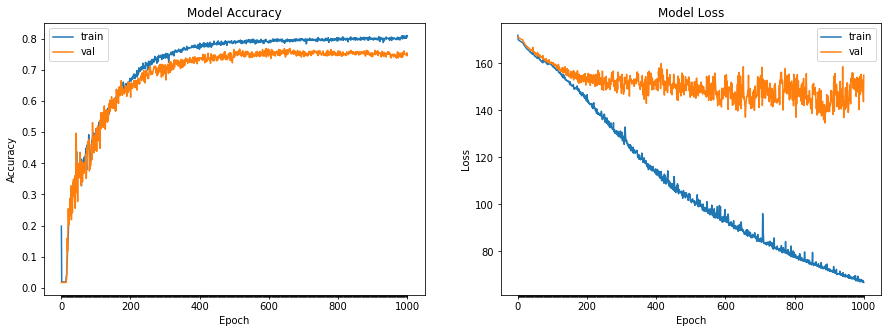

In [25]:
plot_model_history(model_info)

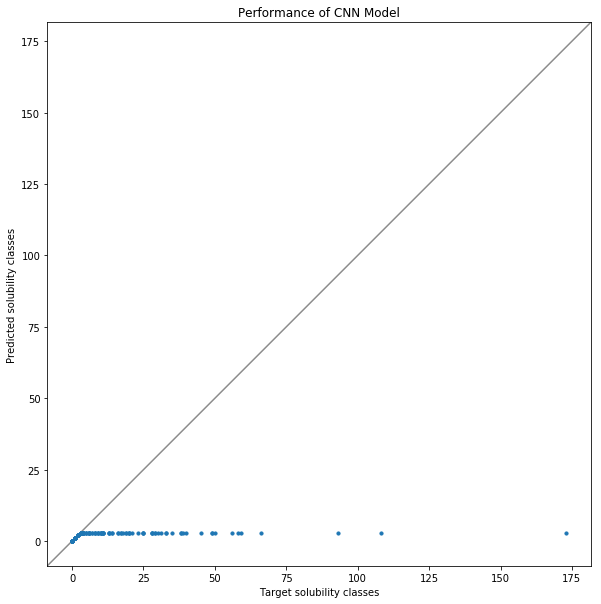

In [31]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.scatter(val_target,np.round(model.predict([val_data_lstm,val_data_mw])), s= 10)
plt.xlabel('Target solubility classes')
plt.ylabel('Predicted solubility classes')
plt.title('Performance of CNN Model')
lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k-', alpha=0.45, zorder=0)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)
plt.show()

In [27]:
from sklearn.metrics import mean_squared_error
# mse = mean_squared_error(val_target, model.predict([val_data_lstm,val_data_mw]))
mse = mean_squared_error(val_target, np.round(model.predict([val_data_lstm,val_data_mw])))

In [28]:
mse*19/200

14.727776923076922

In [29]:
# mean_squared_error(target,model.predict([data_lstm,data_mw]))*19/200
mean_squared_error(target,np.round(model.predict([data_lstm,data_mw])))*19/200

6.4198498845265588

In [30]:
import sklearn
sklearn.metrics.precision_recall_fscore_support(val_target, np.round(model.predict([val_data_lstm,val_data_mw]))
                                               ,average='weighted')

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


(0.72072036856065891, 0.74615384615384606, 0.73293141855064214, None)